<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-for-&quot;Subset-Selection-Based-On-Multiple-Rankings-in-the-Presence-of-Bias:-Effectiveness-of-Fairness-Constraints-for-Multiwinner-Voting-Score-Functions&quot;" data-toc-modified-id="Code-for-&quot;Subset-Selection-Based-On-Multiple-Rankings-in-the-Presence-of-Bias:-Effectiveness-of-Fairness-Constraints-for-Multiwinner-Voting-Score-Functions&quot;-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code for "Subset Selection Based On Multiple Rankings in the Presence of Bias: Effectiveness of Fairness Constraints for Multiwinner Voting Score Functions"</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper functions</a></span><ul class="toc-item"><li><span><a href="#Voting-rules" data-toc-modified-id="Voting-rules-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Voting rules</a></span></li><li><span><a href="#Generative-model-$\hat{\mu}$-given-$\succ\hspace{2mm}-\sim-\mu$" data-toc-modified-id="Generative-model-$\hat{\mu}$-given-$\succ\hspace{2mm}-\sim-\mu$-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generative model $\hat{\mu}$ given $\succ\hspace{2mm} \sim \mu$</a></span></li><li><span><a href="#Metrics-functions" data-toc-modified-id="Metrics-functions-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Metrics functions</a></span></li></ul></li><li><span><a href="#Tools-to-estimate-smoothness-parameters" data-toc-modified-id="Tools-to-estimate-smoothness-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Tools to estimate smoothness parameters</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Run-simulation" data-toc-modified-id="Run-simulation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Run simulation</a></span></li></ul></li></ul></div>

# Code for "Subset Selection Based On Multiple Rankings in the Presence of Bias: Effectiveness of Fairness Constraints for Multiwinner Voting Score Functions" 
---

**Citation:**
Niclas Boehmer, L. Elisa Celis, Lingxiao Huang, Anay Mehrotra, and Nisheeth K. Vishnoi. "*Subset Selection Based On Multiple Rankings in the Presence of Bias: Effectiveness of Fairness Constraints for Multiwinner Voting Score Functions.*" ICML, 2023

URL: https://arxiv.org/pdf/2306.09835.pdf

# Imports

In [1]:
import time
import copy
import random
import pandas as pd
import numpy as np
import itertools


import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import datetime
import string

home_folder = './figures'

from tqdm import tqdm
import mapel.elections as mapel 

In [2]:
# Helper functions
rcParams.update({
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
        'figure.figsize': (10,6),
})

def file_str():
    """ Auto-generates file name."""
    now = datetime.datetime.now()
    return now.strftime("H%HM%MS%S_%m-%d-%y")

rand_string = lambda length: ''.join(random.choice(string.ascii_lowercase) for i in range(length))

def pdf_savefig():
    """ Saves figures as pdf """
    fname = file_str()+rand_string(5)
    plt.savefig(home_folder+f"/{fname}.pdf", bbox_inches="tight")

def eps_savefig():
    """ Saves figure as encapsulated postscript file (vector format)
        so that it isn't pixelated when we put it into a pdf. """
    pdf_savefig()

    


# Helper functions

## Voting rules #######

In [3]:
def get_borda_score(election) -> list:
    """ Return: List with all Borda scores """
    scores = [0 for _ in range(election.num_candidates)]
    for vote in election.votes:
        for c in range(election.num_candidates):
            scores[vote[c]] += c
    return np.array(scores)

def get_sntv_score(election) -> list:
    """ Return: List with all SNTV scores """
    sntv = [_ == 0 for _ in range(election.num_candidates)]
    scores = [0 for _ in range(election.num_candidates)]
    for vote in election.votes:
        for c in range(1):
            scores[vote[c]] += sntv[c]
    return np.array(scores)

def get_bloc_score(election, b) -> list:
    """ Return: List with all SNTV scores """
    bloc = [_ < b for _ in range(election.num_candidates)]
    scores = [0 for _ in range(election.num_candidates)]
    for vote in election.votes:
        for c in range(b):
            scores[vote[c]] += bloc[c]
    return np.array(scores)




## Generative model $\hat{\mu}$ given $\succ\hspace{2mm} \sim \mu$

In [4]:
# Bias function (input: election, phi, groups, output: election_hat)
def get_swapping_bias(election, phi, g1, g2, t_frac):
    
    assert phi < 1
    
    # biased election
    election_hat = copy.deepcopy(election)
    
    # to speed up containment check 
    set_g1 = set(g1)
    set_g2 = set(g2) 
    
    for vote in election_hat.votes: 
        cnt = 0
        maximum_swaps = 0

        # compute maximum number of swaps votes
        for i in np.arange(election_hat.num_candidates):
            if vote[i] in set_g1:
                maximum_swaps += cnt
            if vote[i] in set_g2:
                cnt += 1
            
        t = int(t_frac * maximum_swaps)
        
        # Compute positions 
        pos = [0 for i in range(len(vote))]
        for i in range(len(vote)):
            pos[vote[i]] = i
        
        # Vectorize the computation of V
        p1 = np.array([pos[i] for i in g1])
        p2 = np.array([pos[i] for i in g2])
        v1 = phi ** p1
        v2 = phi ** (-p2)
        
        V = np.outer(v1, v2)
        V = np.where(V > 1, 0, V)
        
        for ind in range(t):
            # Break if no more swaps possible 
            if np.sum(V) == 0: break

            # Sample the pair swapped 
            i = random.choices(np.arange(V.shape[0]), k = 1, weights = np.sum(V, axis=1) / np.sum(V))[0] 
            j = random.choices(np.arange(V.shape[1]), k = 1, weights = V[i, :] / np.sum(V[i, :]))[0] 
             
            # Only do O(n+m) updates to W each step
            V[i, :] = np.where(V[i, :] > 1, 0, V[i, :])
            V[:, j] = np.where(V[:, j] > 1, 0, V[:, j])
            p1[i], p2[j] = p2[j], p1[i]  

        # Generate biased votes using p1 and p2
        for j in range(len(vote)):
            vote[j] = -1
        
        for ijk, i in enumerate(g1):
            vote[p1[ijk]] = i
         
        for ijk, i in enumerate(g2): 
            vote[p2[ijk]] = i
             
    return election_hat

## Metrics functions #######

In [5]:

def get_top_k(scores, k) -> list:
    #print(f'get_top_k, k={k}, len(scores)={len(scores)}')
    assert len(scores) >= k
    return np.argsort(-scores)[:k]

def get_s_ell(scores, k, l, g1, g2) -> list:
    scores_g1 = scores[g1]
    scores_g2 = scores[g2]
    
    cand_g1 = np.argsort(-scores_g1)[:k-l]
    cand_g2 = np.argsort(-scores_g2)[:l] 
    
    assert len(g1) >= k-l
    assert len(g2) >= l
    
    cand_g1 = list(g1[cand_g1])
    cand_g2 = list(g2[cand_g2])
    
    return np.array(cand_g1 + cand_g2)


In [6]:
# Select committee maximizing score and
# output the properties of the selected committee
def get_committee_score_const(scores_hat, g1, g2, l, k, scores):
    if l != -1:
        s_ell = get_s_ell(scores_hat, k, l, g1, g2)
    else:
        s_ell = get_top_k(scores_hat, k) 
        
    assert len(s_ell) == k
    return np.sum(scores[s_ell])

def get_committee_score_opt(scores_hat, g1, g2, l, k, scores):
    s = get_top_k(scores, k)
    
    assert len(s) == k
    return np.sum(scores[s])

# Tools to estimate smoothness parameters

In [7]:
def get_alpha(
    multiwinner_function,
    generative_models,
    ITER=10,
    NUM_C=10,
    NUM_V=10,
    DELTA=1e-2,
    tau_1=lambda x: 1,
):
    """
        multiwinner_function: 
            input: election
            output: float 

        generative_models: tuple
            latent_generative_model:
                input: num_cand, num_voters
                output: latent_election with `num_cand` candidates and `num_voters` voters

            biased_generative_model:
                input: latent_election, group1, group2
                output: biased_election

        ITER: Number of times to repeat the simulation
        
        NUM_C: Number of candidates
        
        NUM_V: Number of voters
        
        DELTA: DELTA to use when computing the error bound; the bound holds with probabilty > 1 - DELTA
        
        tau_1: Function which given, NUM_C, outputs the tau_1 value of the submodular function (as defined in the paper)
    """

    latent_generative_model, biased_generative_model = generative_models

    tau_1 = tau_1(NUM_C) # Compute tau_1(multiwinner_function) -- see Definition 4.1 in the paper
    
    # Construct protected groups
    g1 = np.random.choice(np.arange(NUM_C), NUM_C // 2, replace=False)
    set_g1 = set(g1)
    g2 = []
    for i in np.arange(NUM_C):
        if i not in set_g1:
            g2.append(i)
    g2 = np.array(g2)

    
    # Compute expected latent scores and biased scores
    scores = np.zeros(NUM_C)
    scores_hat = np.zeros(NUM_C)
    
    alpha_list = []
    
    for ijk in tqdm(range(ITER)):
        election = latent_generative_model(NUM_C, NUM_V)
        election_hat = biased_generative_model(election, g1, g2)

        # Compute scores
        scores_ = multiwinner_function(election)
        scores_hat_ = multiwinner_function(election_hat) 
        
        scores +=  scores_ / ITER
        scores_hat += scores_hat_ / ITER
        
        alpha_list.append(1 / tau_1 * min(np.min(scores_), np.min(scores_hat_)))

    
    # Compute Alpha
    lb_on_alpha = 1 / tau_1 * min(np.min(scores), np.min(scores_hat)) / NUM_V
    alpha = lb_on_alpha # Estimate alpha by lowerbound

    
    alpha_err = np.std(alpha_list) / np.sqrt(ITER) # Estimate empirical error-bounds on alpha
    
    beta = pd.Series(np.linspace(min(scores) / max(scores), 1, 100), name='beta')
    beta_err = pd.Series(0, name='beta', index=beta.index)
    
    def get_gamma(beta):
        
        gamma = 0
        
        for i, j in itertools.combinations(g1, 2):
            if beta * scores[i] >= scores[j]:
                gamma = max(gamma, scores_hat[j] / scores_hat[i])
                
        for i, j in itertools.combinations(g2, 2):
            if beta * scores[i] >= scores[j]:
                gamma = max(gamma, scores_hat[j] / scores_hat[i])
        
        gamma_error = alpha_err * NUM_V / np.min(scores_hat)

        return gamma, gamma_error

    df_beta_gamma = pd.DataFrame({'beta':
        beta,
        'beta_err':
        beta_err,
        'gamma':
        pd.Series([get_gamma(beta_)[0] for beta_ in beta], index=beta.index),
        'gamma_err':
        pd.Series([get_gamma(beta_)[1] for beta_ in beta], index=beta.index)
    })

    return {
        'alpha':
        alpha,
        'alpha_err':
        alpha_err,
        'df_beta_gamma': df_beta_gamma}
        

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 102.81it/s]


Result for Borda
Latent generative model: impartial_culture
	alpha: 0.42 +/- 0.02


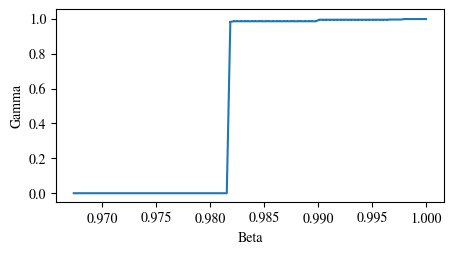

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 91.79it/s]


Result for Borda
Latent generative model: urn
	alpha: 0.42 +/- 0.05


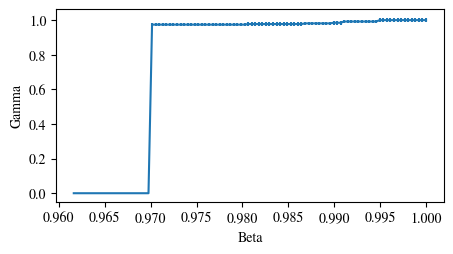

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 94.98it/s]


Result for Borda
Latent generative model: mallows
	alpha: 0.13 +/- 0.04


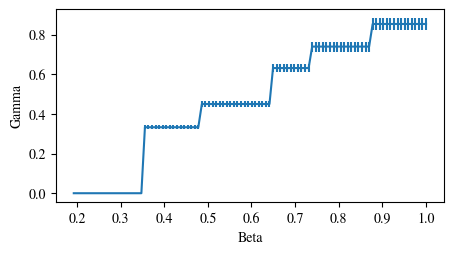

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 81.47it/s]


Result for Borda
Latent generative model: norm-mallows
	alpha: 0.2 +/- 0.05


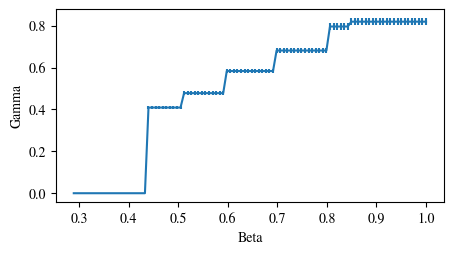

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 87.44it/s]


Result for Borda
Latent generative model: conitzer
	alpha: 0.29 +/- 0.02


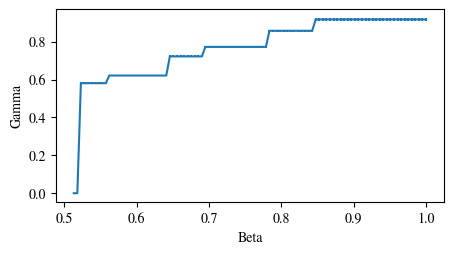

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 92.24it/s]


Result for SNTV
Latent generative model: impartial_culture
	alpha: 0.01 +/- 0.0


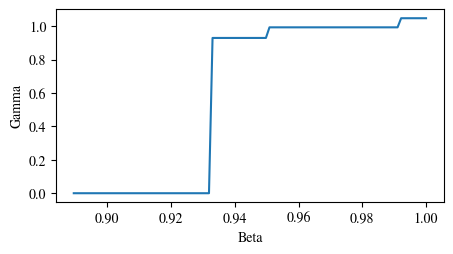

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 91.49it/s]


Result for SNTV
Latent generative model: urn
	alpha: 0.01 +/- 0.0


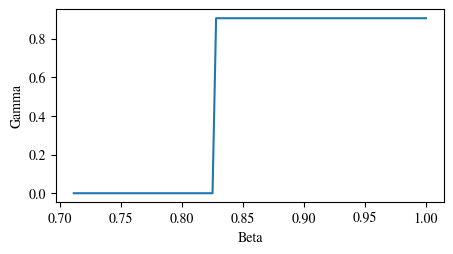

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 69.33it/s]


Result for SNTV
Latent generative model: mallows
	alpha: 0.0 +/- 0.0


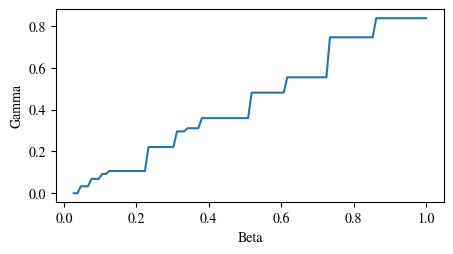

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 88.64it/s]


Result for SNTV
Latent generative model: norm-mallows
	alpha: 0.0 +/- 0.0


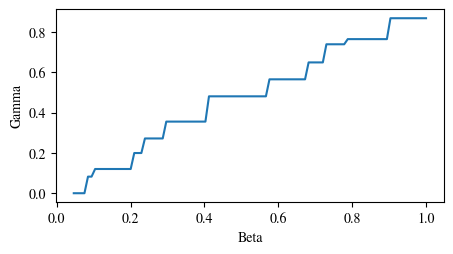

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 83.51it/s]


Result for SNTV
Latent generative model: conitzer
	alpha: 0.0 +/- 0.0


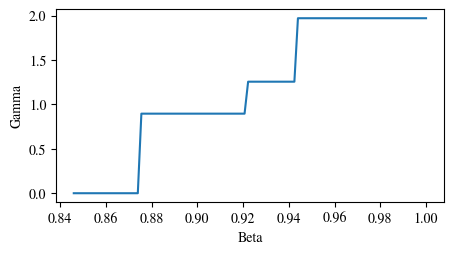

In [8]:
multiwinner_rules = [get_borda_score, get_sntv_score]
multiwinner_rule_names = ['Borda', 'SNTV']
biased_generative_model = lambda election, g1, g2: get_swapping_bias(election, 1e-4, g1, g2, 0.9)

for multiwinner_rule, multiwinner_rule_name in zip(multiwinner_rules, multiwinner_rule_names):
    for dist in [
                'impartial_culture', 'urn', 'mallows', 'norm-mallows', 'conitzer'
        ]:

        latent_generative_model = get_election = lambda x, y: mapel.generate_election(culture_id = dist,\
                                                            num_candidates = x,\
                                                            num_voters = y)

        
        res = get_alpha(multiwinner_rule, (latent_generative_model, biased_generative_model), ITER=500, NUM_C=10, NUM_V=10, tau_1=lambda x: x)

        
        print(f'Result for {multiwinner_rule_name}')
        print(f'Latent generative model: {dist}')

        print(f"\talpha: {np.round(res['alpha'], 2)} +/- {np.round(res['alpha_err'], 2)}")

        plt.figure(figsize=(5, 2.5))
        plt.errorbar(x=res['df_beta_gamma']['beta'], y=res['df_beta_gamma']['gamma'], yerr=res['df_beta_gamma']['gamma'] * res['df_beta_gamma']['gamma_err'])
        plt.xlabel('Beta')
        plt.ylabel('Gamma')
        plt.show()

        print('=' * 30)
        print('')
        
    print('=' * 50)
    print('=' * 50)



# Simulation

## Parameters 

In [9]:
p = 2 
k = 10
ITER = 40
 

get_election = lambda x, y: mapel.generate_election(culture_id = 'norm-mallows',\
                                                    num_candidates = x,\
                                                    num_voters = y)

rules = ['Borda', '10-Bloc', 'SNTV']

colors = {}
colors['Borda'] = '#377eb8'
colors['10-Bloc'] = '#ff7f00'
colors['SNTV'] = '#4daf4a'

get_score = {}
get_score['Borda'] = lambda x: get_borda_score(x)
get_score['SNTV'] = lambda x: get_sntv_score(x)
get_score['10-Bloc'] = lambda x: get_bloc_score(x, 10)

## Run simulation

100%|█████████████████████████████████████████████| 8/8 [07:48<00:00, 58.52s/it]


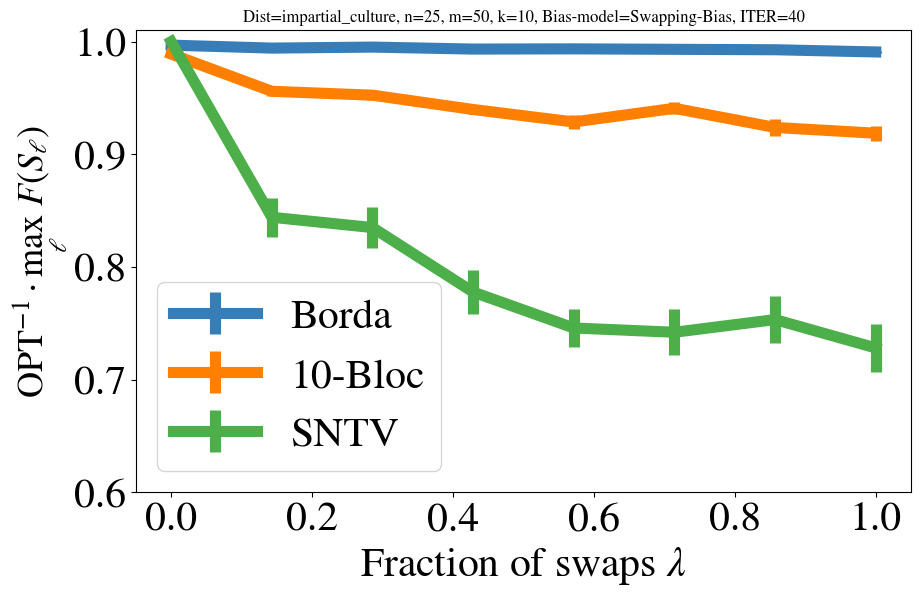

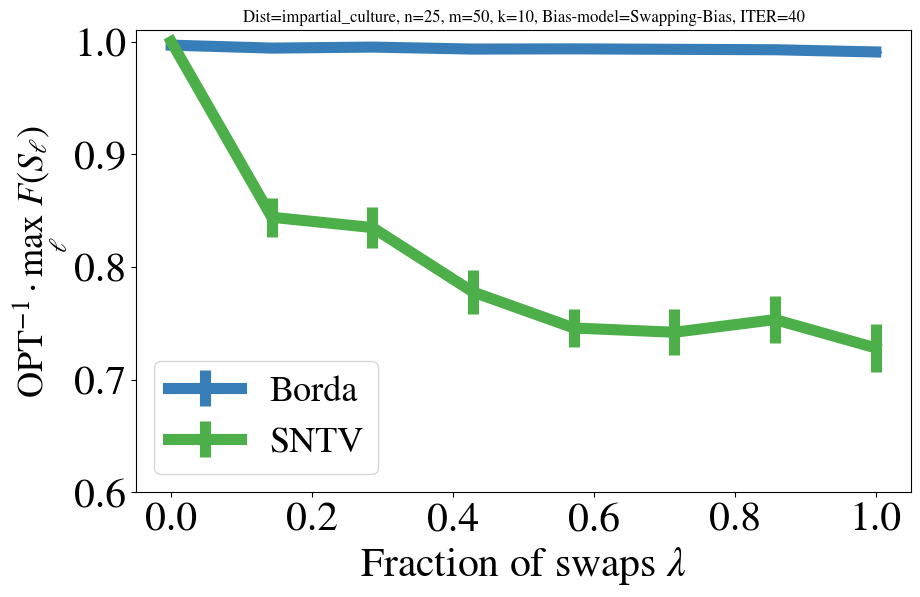

100%|█████████████████████████████████████████████| 8/8 [07:50<00:00, 58.81s/it]


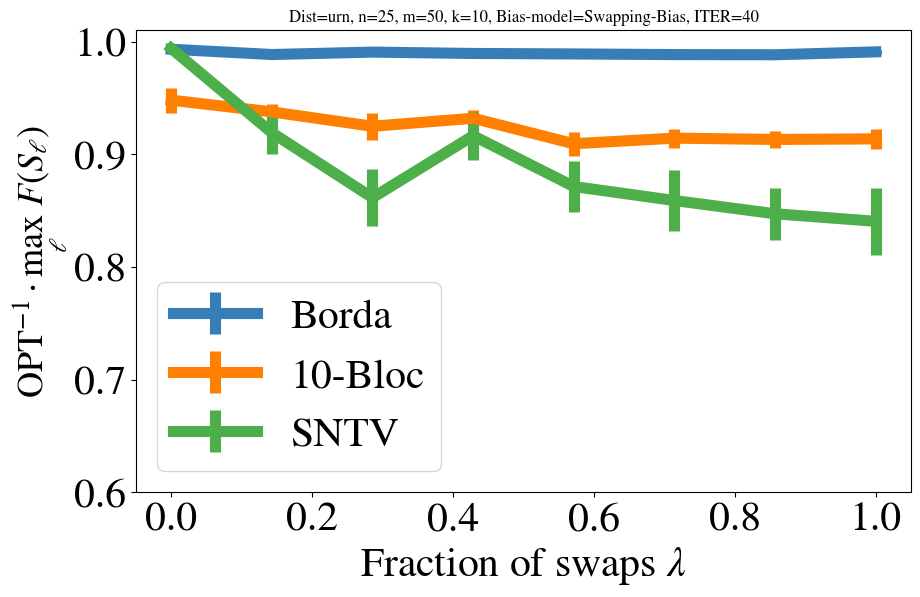

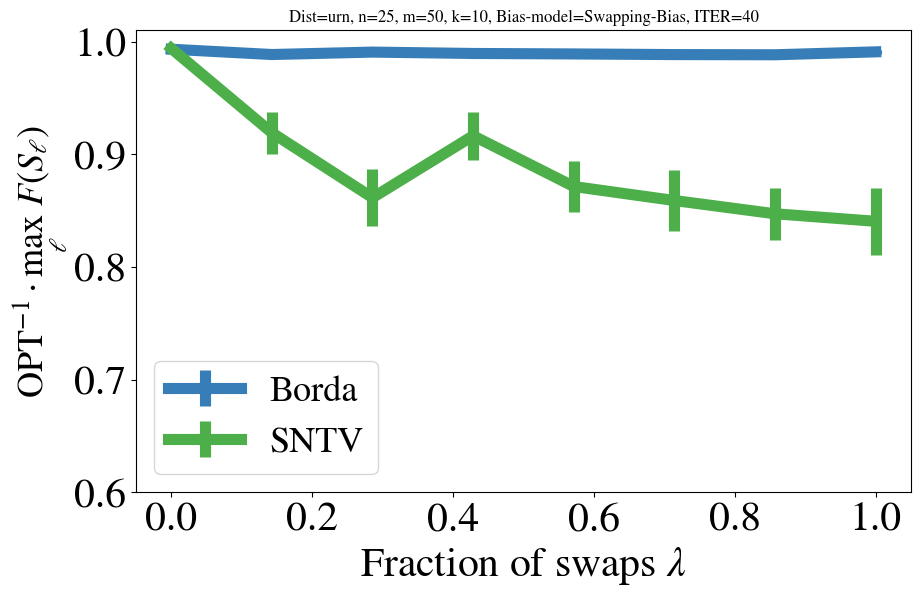

100%|█████████████████████████████████████████████| 8/8 [09:48<00:00, 73.55s/it]


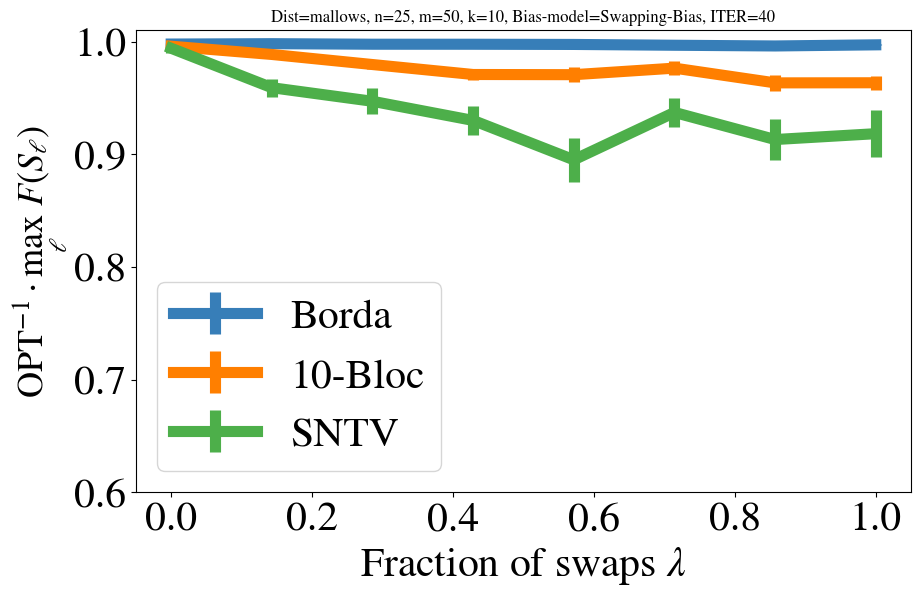

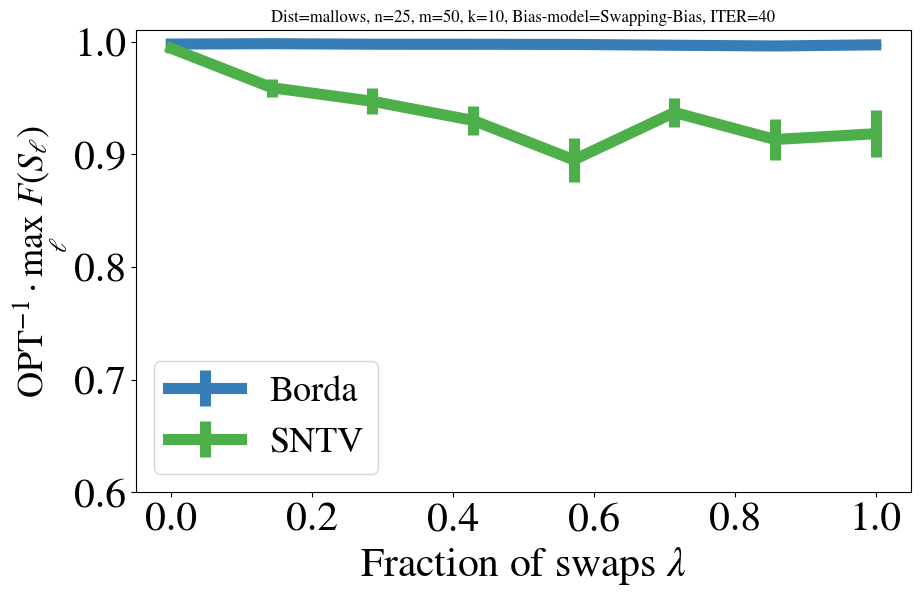

100%|█████████████████████████████████████████████| 8/8 [07:36<00:00, 57.12s/it]


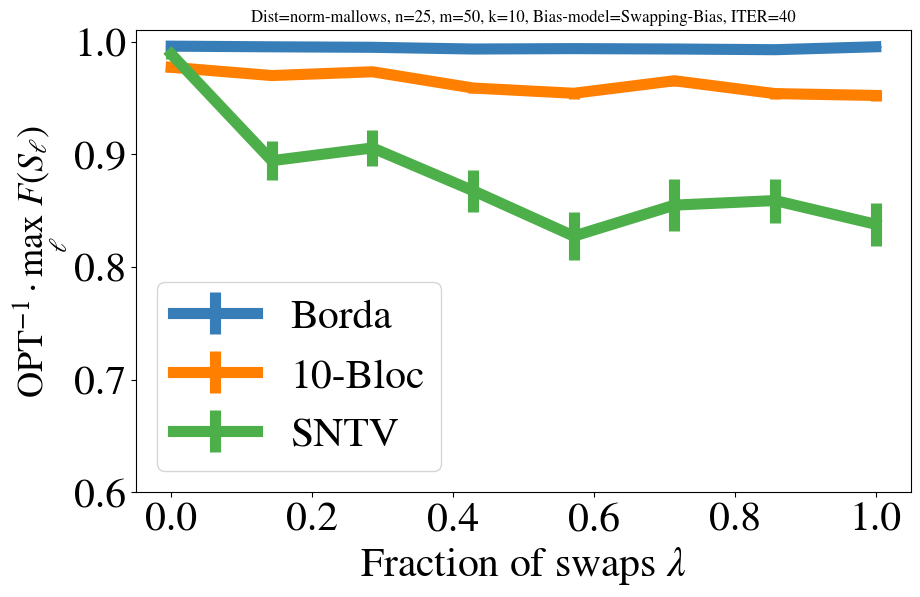

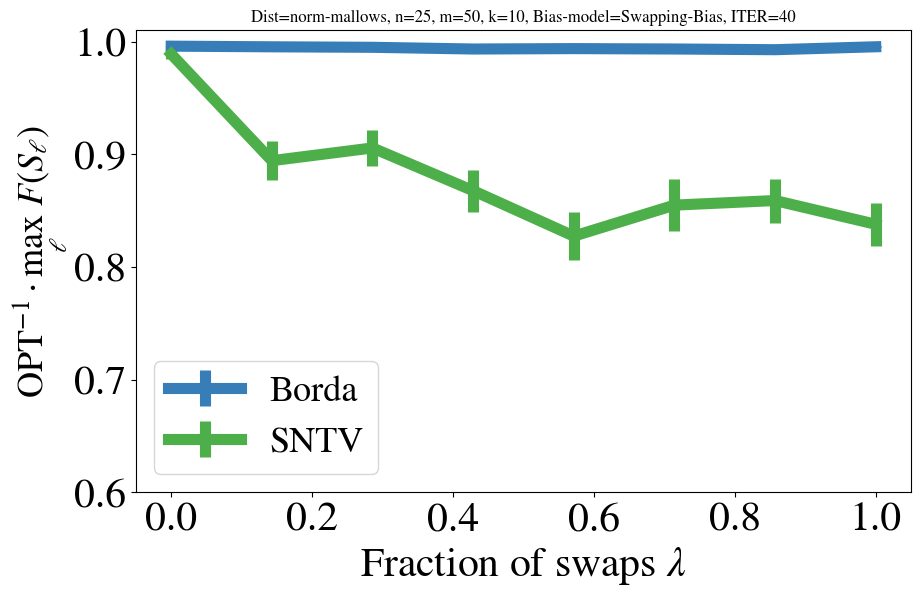

100%|█████████████████████████████████████████████| 8/8 [08:53<00:00, 66.74s/it]


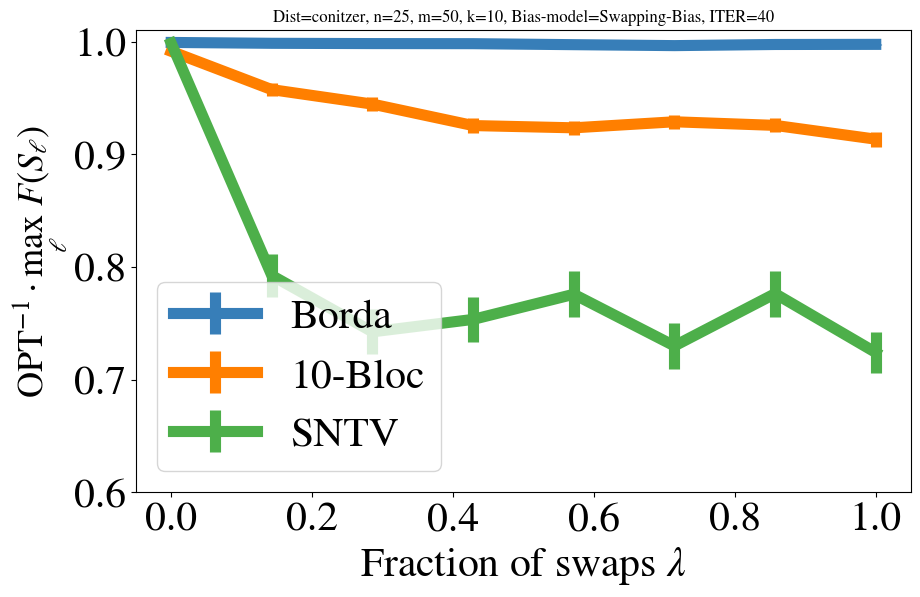

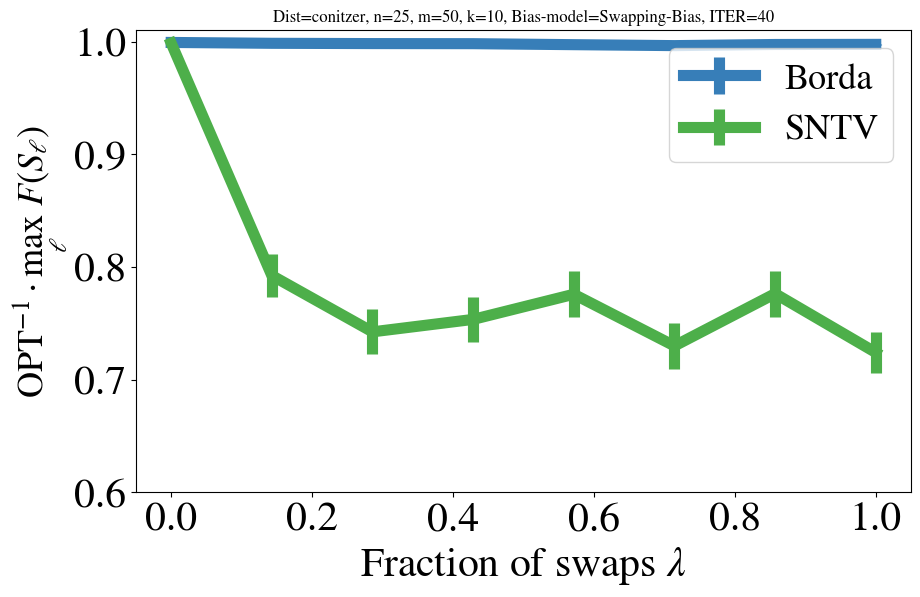

100%|████████████████████████████████████████████| 8/8 [16:18<00:00, 122.37s/it]


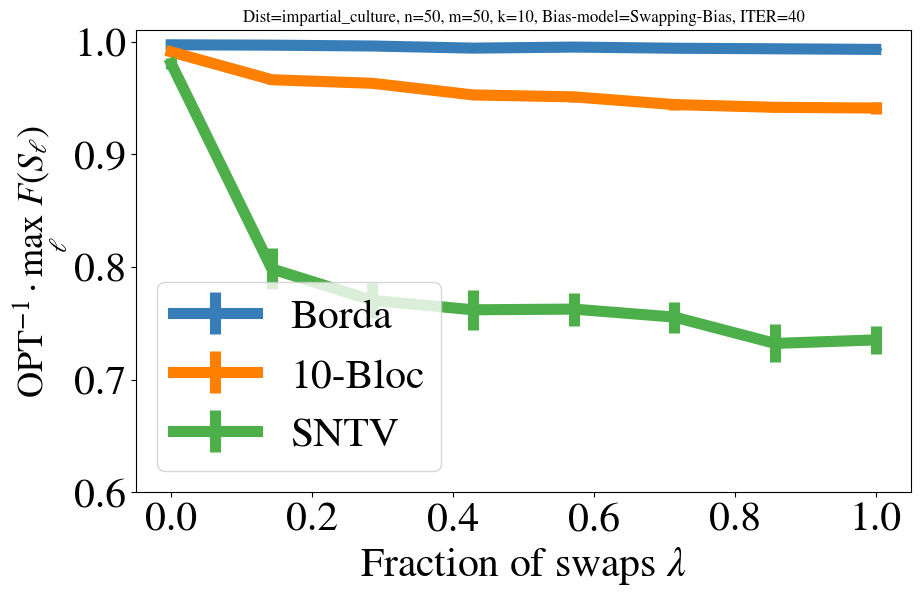

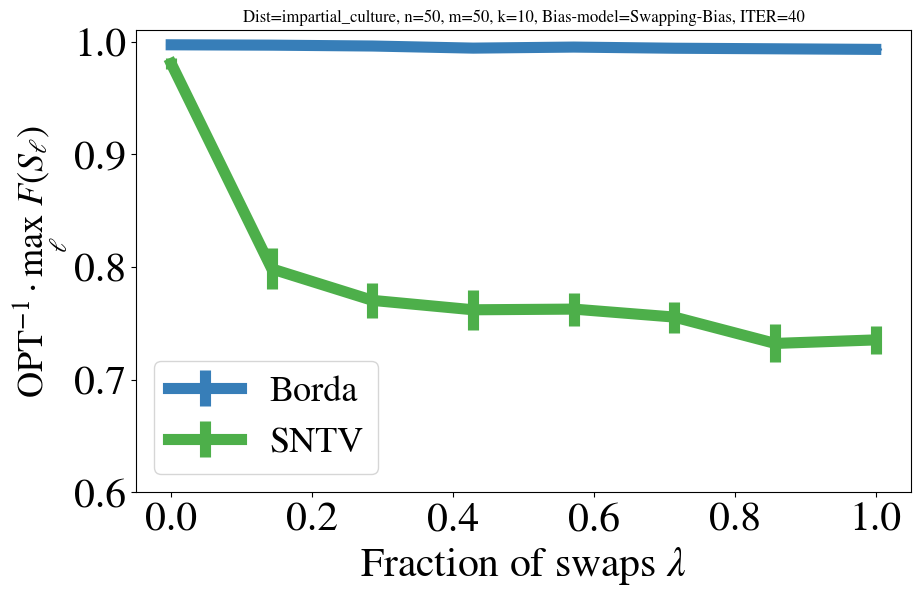

100%|████████████████████████████████████████████| 8/8 [16:19<00:00, 122.39s/it]


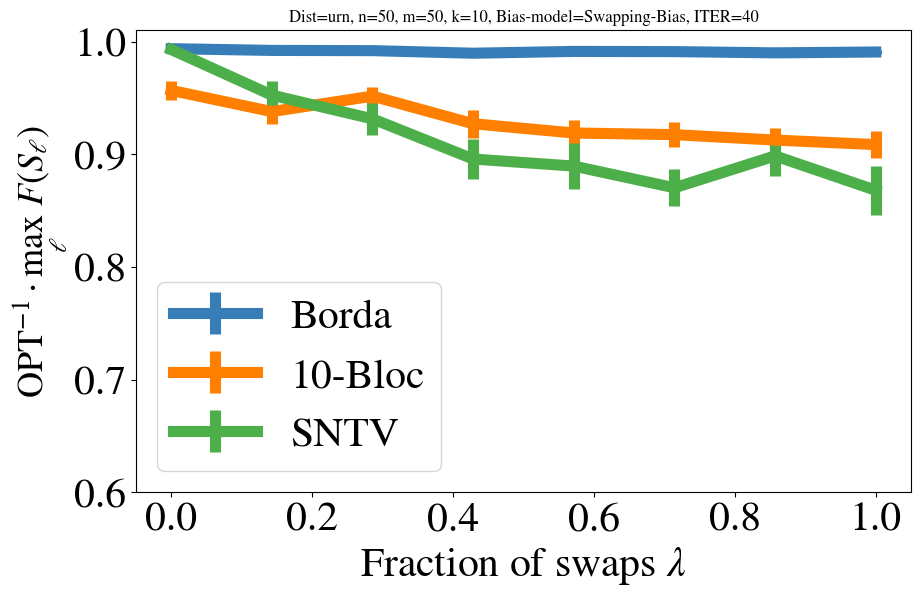

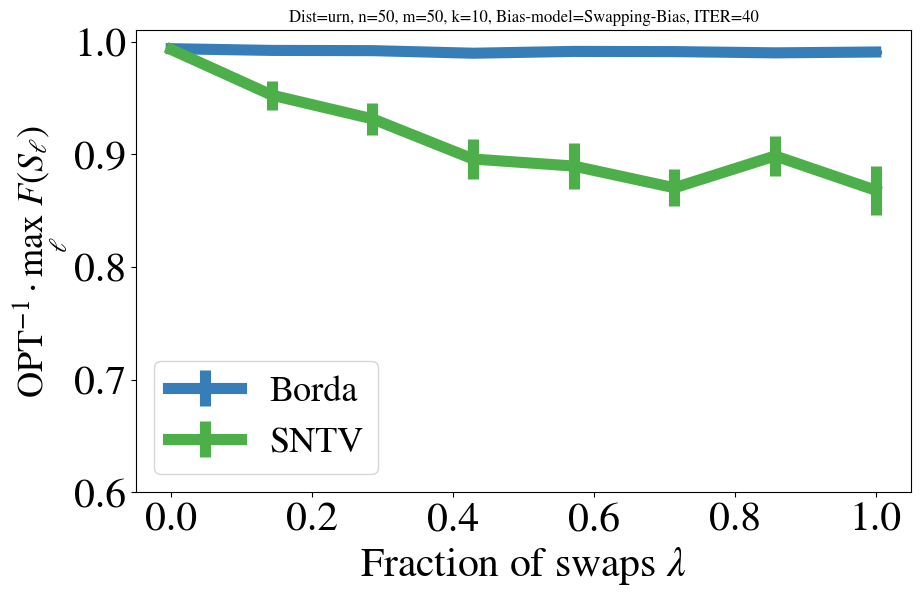

100%|████████████████████████████████████████████| 8/8 [20:18<00:00, 152.26s/it]


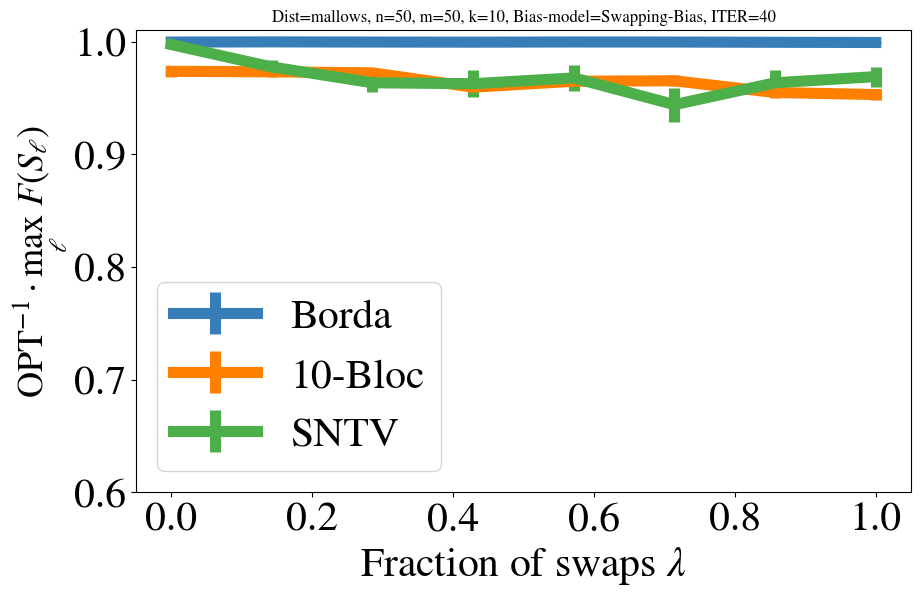

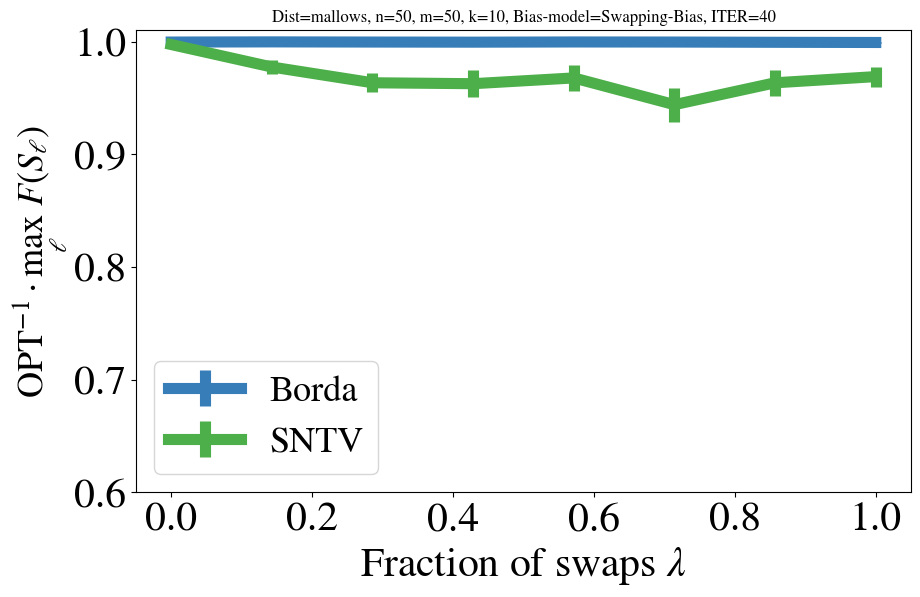

100%|████████████████████████████████████████████| 8/8 [15:09<00:00, 113.72s/it]


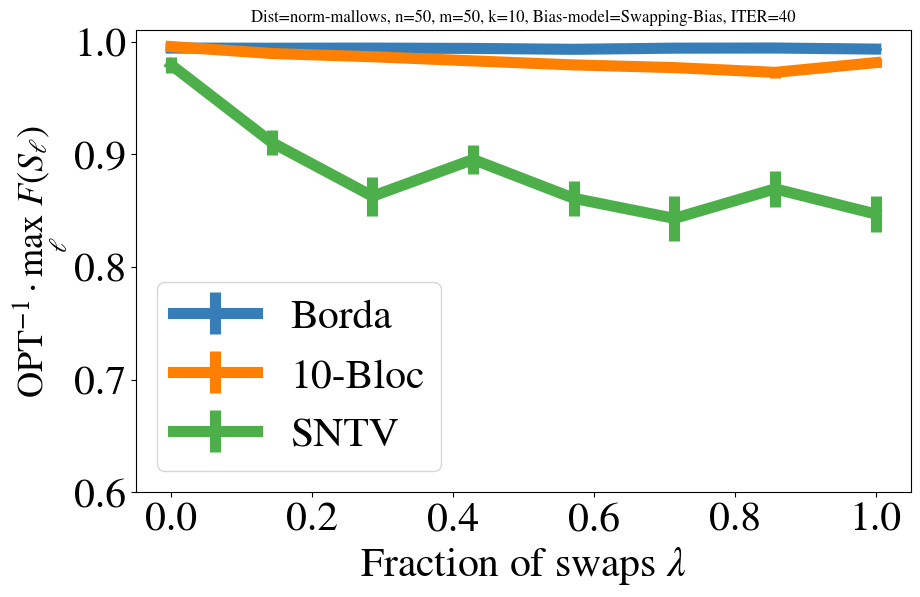

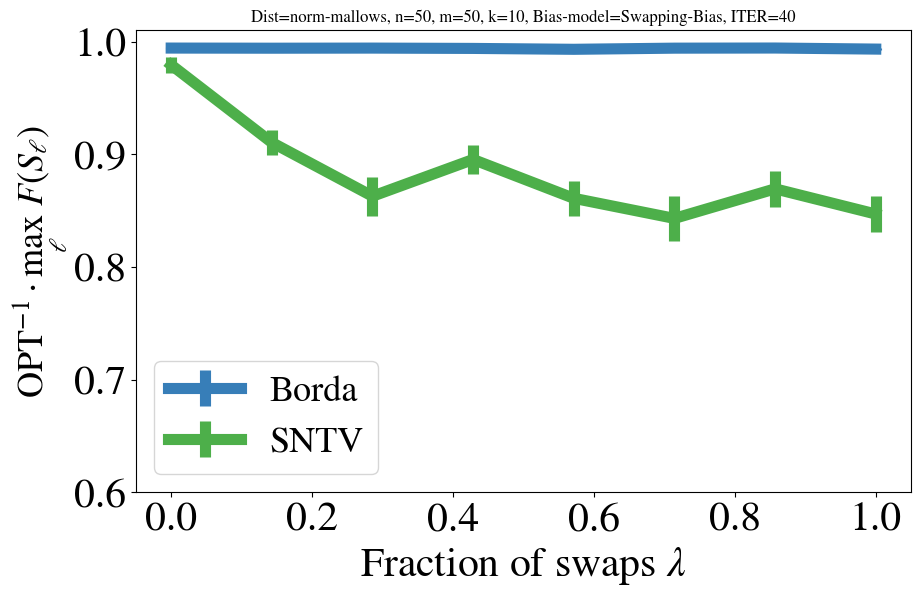

100%|████████████████████████████████████████████| 8/8 [18:38<00:00, 139.83s/it]


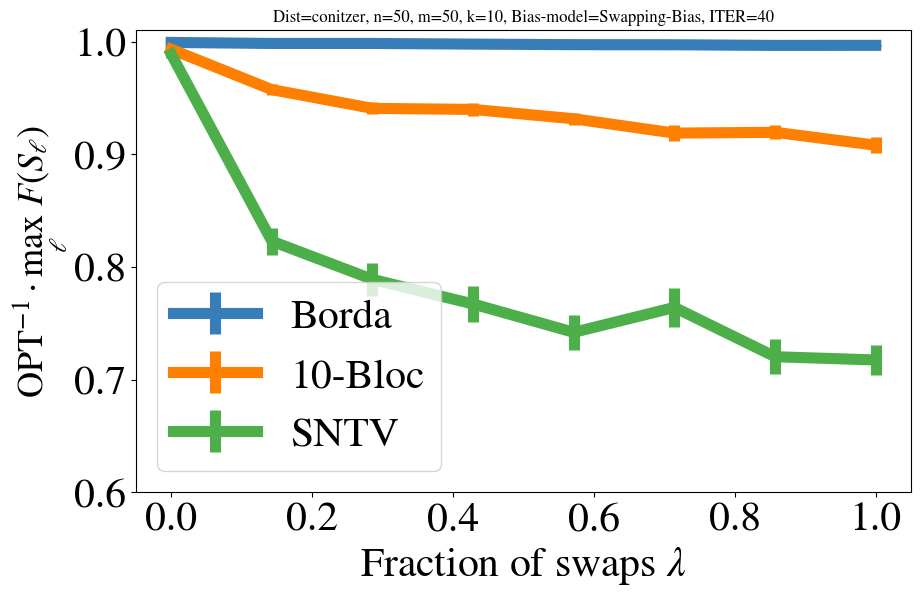

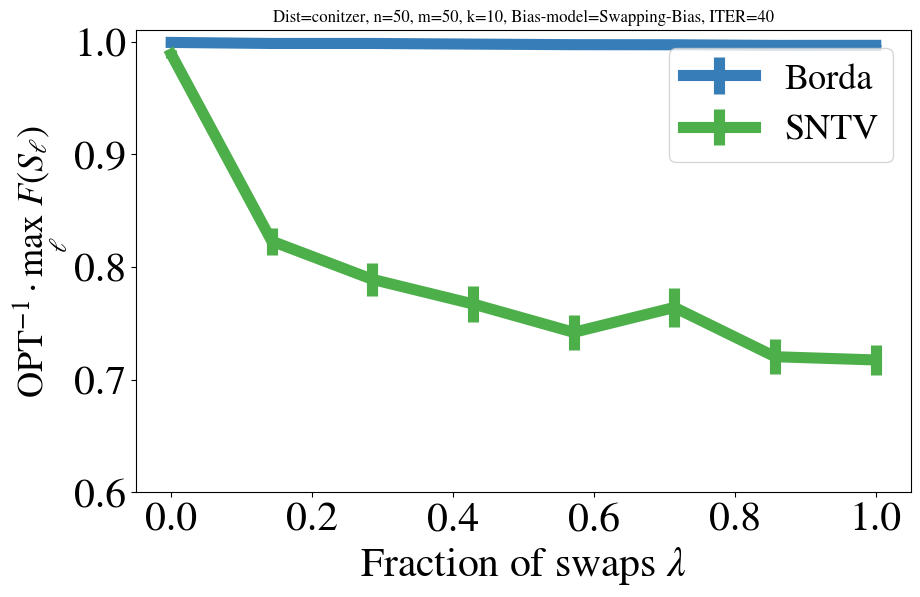

100%|████████████████████████████████████████████| 8/8 [32:15<00:00, 241.89s/it]


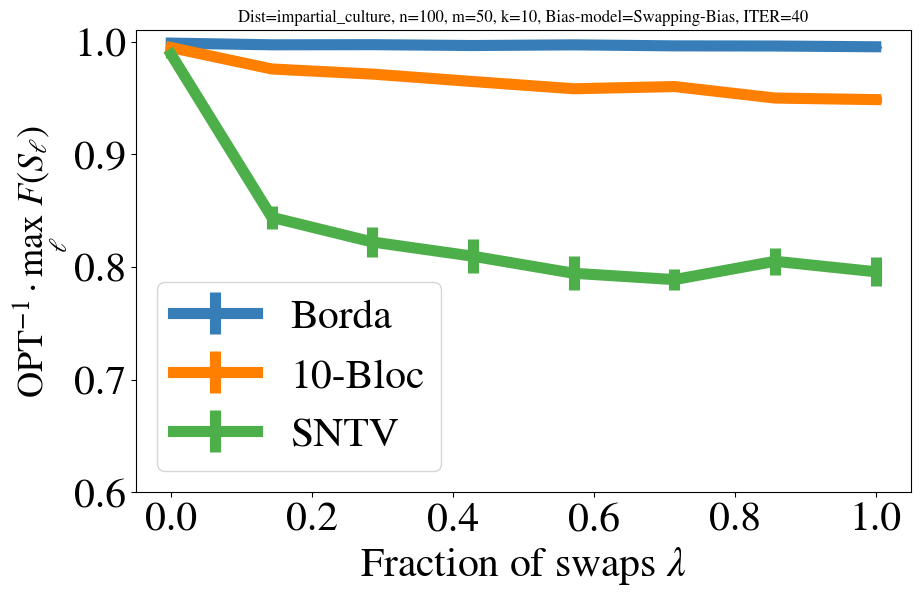

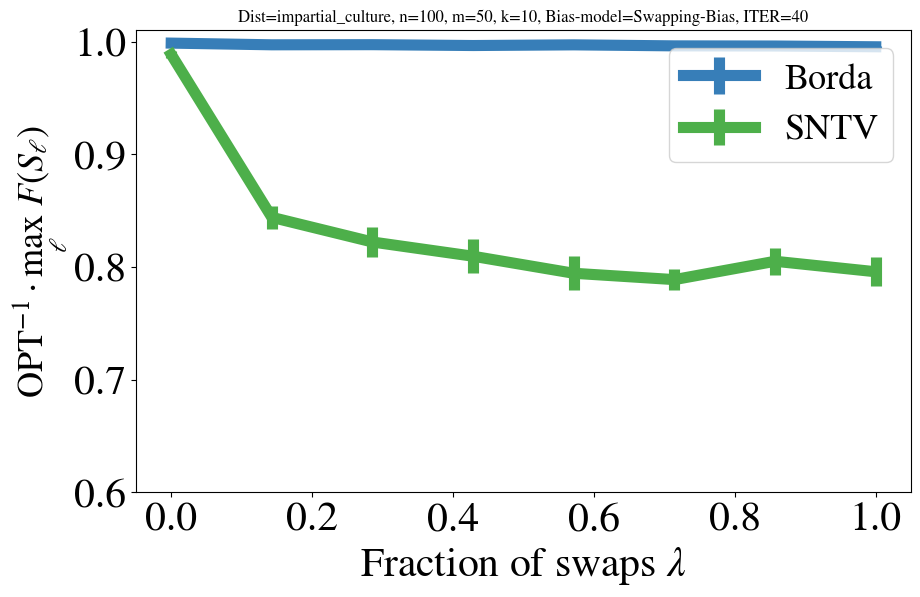

100%|████████████████████████████████████████████| 8/8 [32:02<00:00, 240.35s/it]


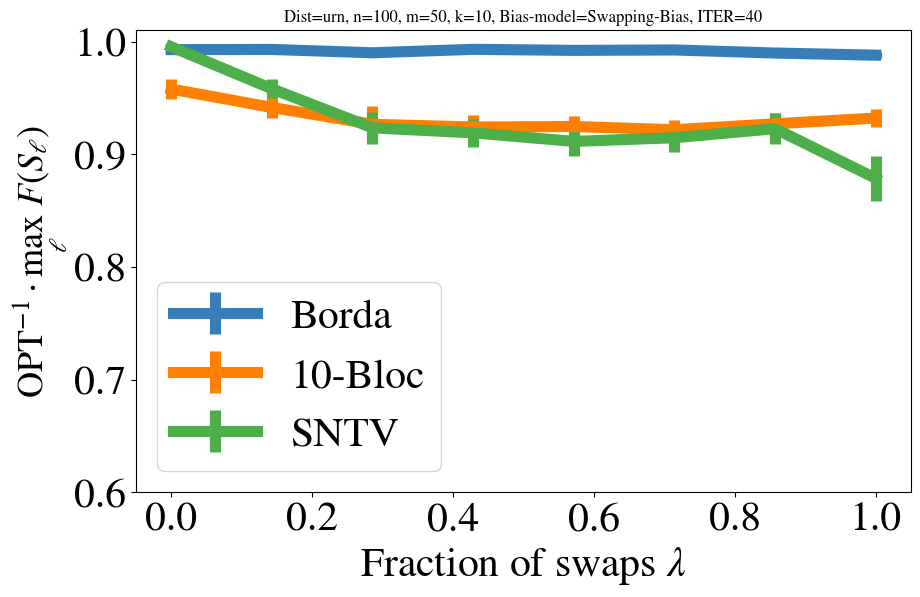

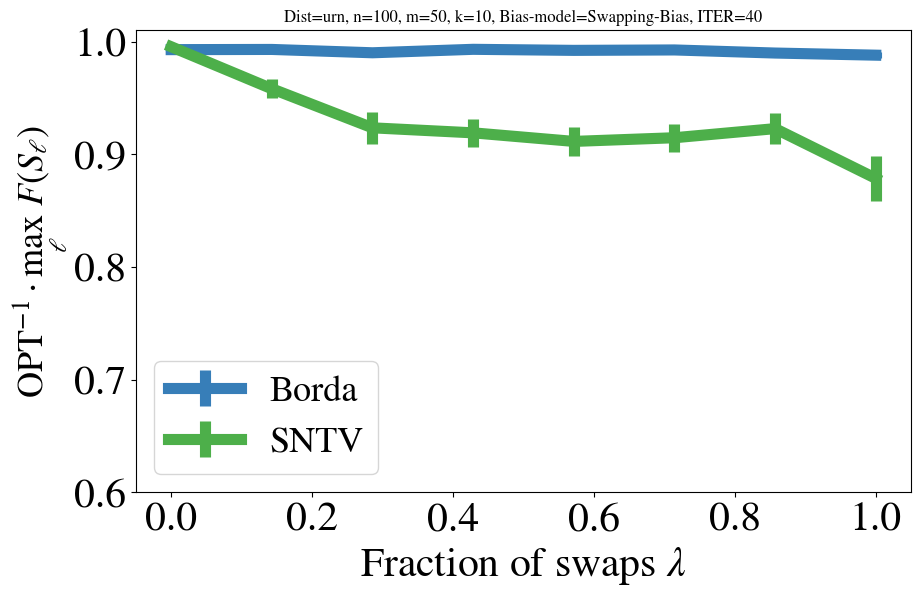

100%|████████████████████████████████████████████| 8/8 [25:51<00:00, 193.89s/it]


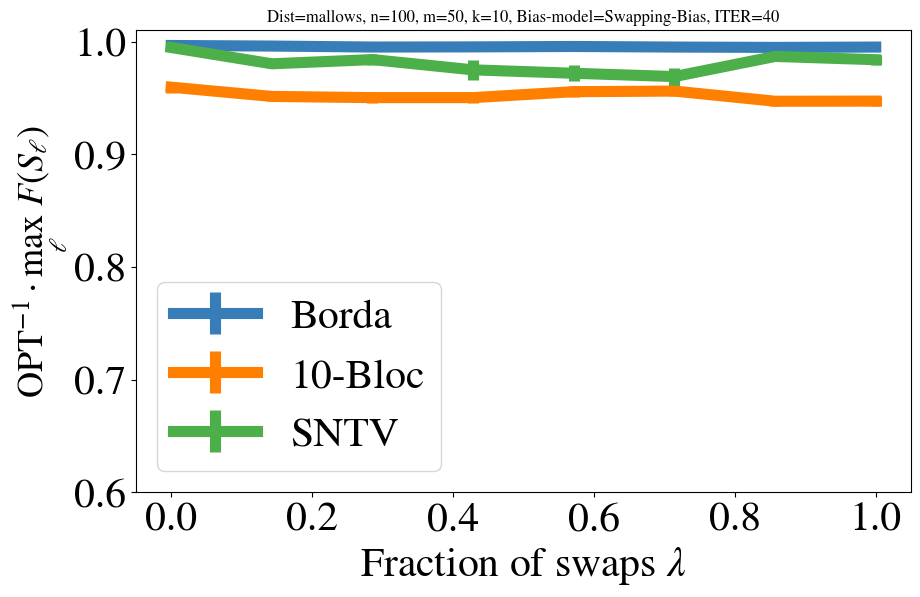

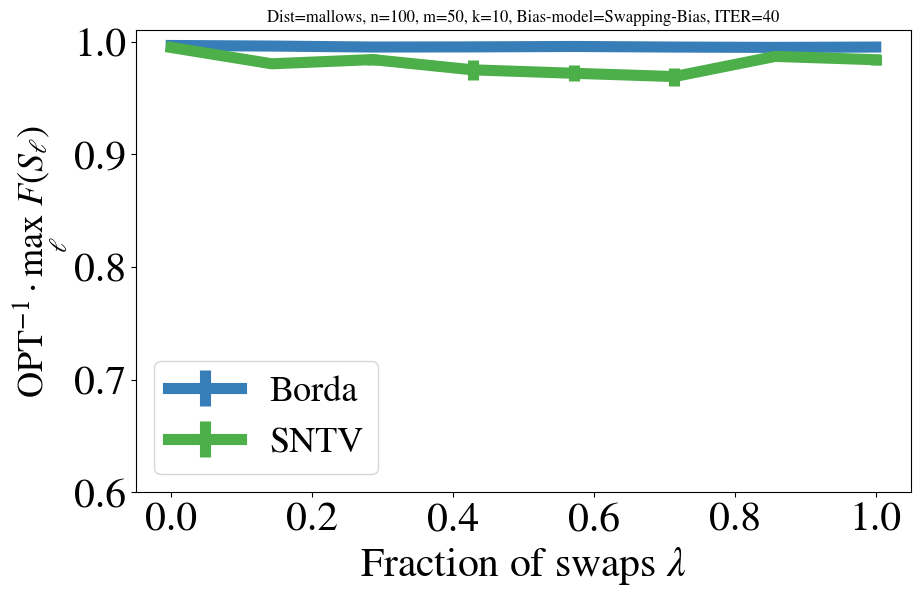

100%|████████████████████████████████████████████| 8/8 [33:22<00:00, 250.36s/it]


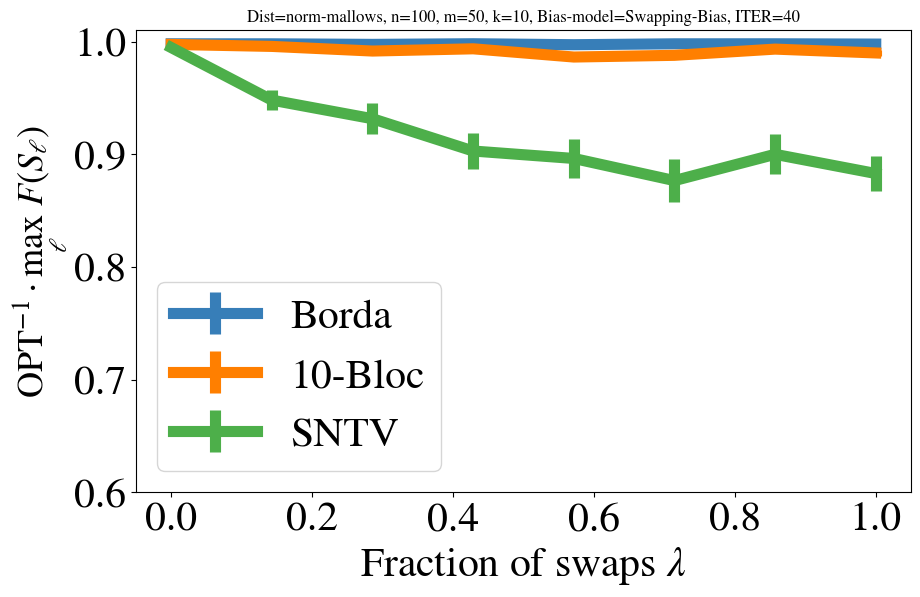

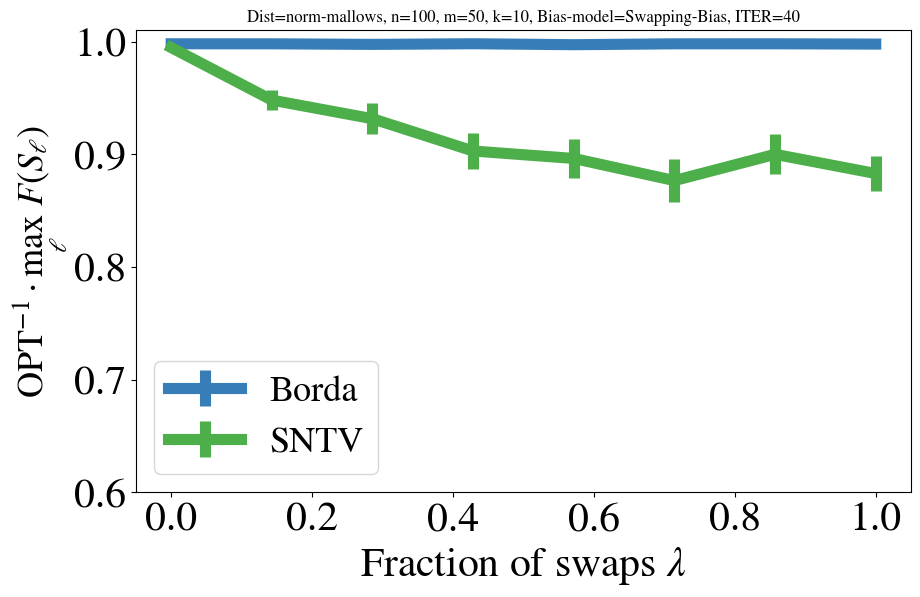

100%|█████████████████████████████████████████| 8/8 [2:39:53<00:00, 1199.24s/it]


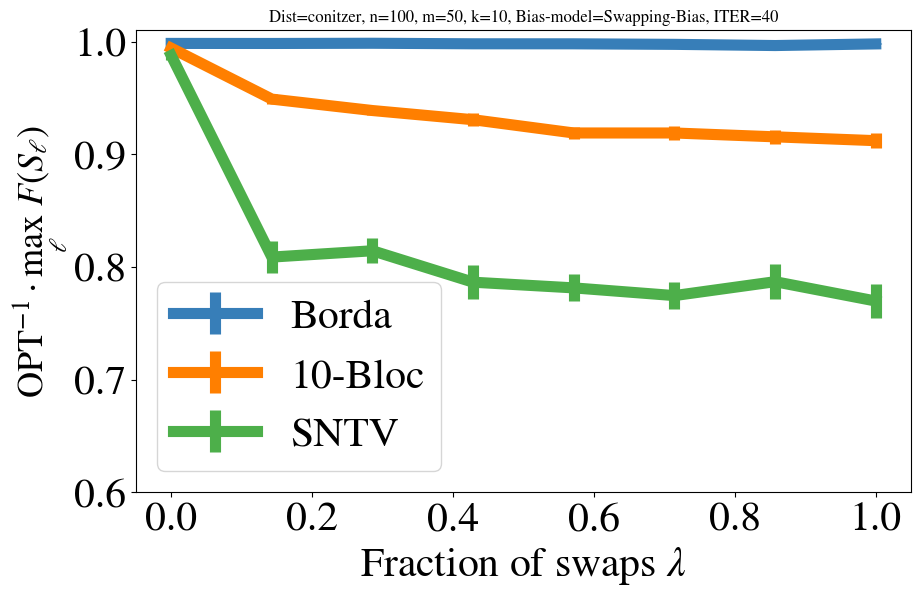

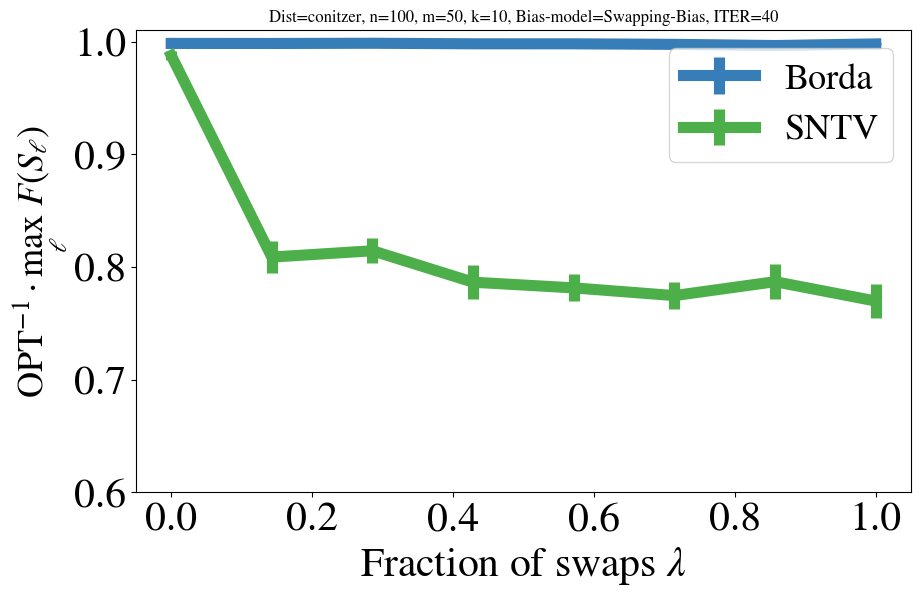

In [12]:
for n, m in itertools.product([25, 50, 100], [50]):
    for dist in [
            'impartial_culture', 'urn', 'mallows', 'norm-mallows', 'conitzer'
    ]:
        get_election = lambda x, y: mapel.generate_election(culture_id = dist,\
                                                    num_candidates = x,\
                                                    num_voters = y)
        lb_list = np.round(np.linspace(0, 1, 10) * min(k, m / 2))

        frac_swaps_list = np.linspace(0, 1, 8)

        g1 = np.random.choice(np.arange(m), m // 2, replace=False)
        set_g1 = set(g1)
        g2 = []
        for i in np.arange(m):
            if i not in set_g1:
                g2.append(i)
        g2 = np.array(g2)

        best_ratio_ye_const = {r: [] for r in rules}
        best_ratio_ye_const_std = {r: [] for r in rules}

        phi = 0.5

        for frac_swaps in tqdm(frac_swaps_list):
            for r in rules:  # Append best ratio
                best_ratio_ye_const[r].append(-1)
                best_ratio_ye_const_std[r].append(-1)

            for lb in np.arange(0, k + 1, 2):
                lb = int(lb)

                ratio_no_const = {r: [] for r in rules}
                ratio_ye_const = {r: [] for r in rules}

                for ijk in range(ITER):
                    election = get_election(m, n)
                    election_hat = get_swapping_bias(election, phi, g1, g2,
                                                     frac_swaps)

                    for r in rules:
                        scores = get_score[r](election)
                        scores_hat = get_score[r](election_hat)

                        # find the committees: with constraints and the optimal committee
                        score_ye_const = get_committee_score_const(
                            scores_hat, g1, g2, lb, k, scores)
                        score_opt = get_committee_score_opt(
                            scores, g1, g2, 0, k, scores)

                        #print(f'scores={scores}')
                        #print(f'score_opt={score_opt}\tscore_ye_const={score_ye_const}')

                        assert (score_opt >= score_ye_const)

                        # evaluations
                        ratio_ye_const[r].append(score_ye_const /
                                                 (score_opt + 1e-18))

                ratio_ye_const_mean = {r: [] for r in rules}
                ratio_ye_const_std = {r: [] for r in rules}
                for r in rules:  # Updates to ratio
                    ratio_ye_const_mean[r] = np.mean(ratio_ye_const[r])
                    ratio_ye_const_std[r] = np.std(
                        ratio_ye_const[r]) / np.sqrt(ITER)

                    assert (ratio_ye_const_mean[r] <= 1 + 1e-5)

                for r in rules:  # Updates to best ratio
                    if best_ratio_ye_const[r][-1] < ratio_ye_const_mean[r]:
                        best_ratio_ye_const_std[r][-1] = ratio_ye_const_std[r]

                    best_ratio_ye_const[r][-1] = max(
                        best_ratio_ye_const[r][-1], ratio_ye_const_mean[r])

        ####################################
        # PLOT 1
        ####################################
        plt.title(
            f'Dist={dist}, n={n}, m={m}, k={k}, Bias-model=Swapping-Bias, ITER={ITER}'
        )
        plt.ylabel('${\\rm OPT}^{-1} \cdot \max_\ell\ F(S_\ell)$', fontsize=26)
        plt.xlabel('Fraction of swaps $\\lambda$', fontsize=30)
        plt.ylim(0.6, 1.01)

        for r in rules:
            plt.errorbar(frac_swaps_list,
                         best_ratio_ye_const[r],
                         yerr=best_ratio_ye_const_std[r],
                         linewidth=8,
                         label=r,
                         color=colors[r])

        plt.legend(fontsize=30, shadow=False)
        plt.tick_params(axis='both', which='major', labelsize=30)
        plt.show()
        #pdf_savefig()
        plt.close()

        ####################################
        # PLOT 2
        ####################################
        plt.title(
            f'Dist={dist}, n={n}, m={m}, k={k}, Bias-model=Swapping-Bias, ITER={ITER}'
        )
        plt.ylabel('${\\rm OPT}^{-1} \cdot \max_\ell\ F(S_\ell)$', fontsize=26)
        plt.xlabel('Fraction of swaps $\\lambda$', fontsize=30)
        plt.ylim(0.6, 1.01)

        for r in ['Borda', 'SNTV']:
            plt.errorbar(frac_swaps_list,
                         best_ratio_ye_const[r],
                         yerr=best_ratio_ye_const_std[r],
                         linewidth=8,
                         label=r,
                         color=colors[r])

        plt.legend(fontsize=26, shadow=False)
        plt.tick_params(axis='both', which='major', labelsize=30)
        plt.show()
        #pdf_savefig()
        plt.close()